In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
mpl.rcdefaults()
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['text.color'] = '#909090'
mpl.rcParams['axes.labelcolor']= '#909090'
mpl.rcParams['xtick.color'] = '#909090'
mpl.rcParams['ytick.color'] = '#909090'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18
plt.rcParams['image.cmap'] = 'jet'

In [3]:
# Load the true test fields
test_true = np.load('sst_var_test',allow_pickle=True)[1318:1486]
# Load the mask
mask = np.load('mask',allow_pickle=True)

for week in range(168):
    test_true[week] = test_true[week]*mask[0]
    
# Load the HYCOM fields
test_hycom = np.load('HYCOM_Data_Interpolated.npy')

# Load the Predicted fields
test_pred = np.load('RKHS_Predicted_Fields.npy')[1318:1486]

# Load CESM fields
test_cesm = np.load('CESM_Test_Fields.npy')[1318:1486]
for week in range(168):
    test_cesm[week] = test_cesm[week]*mask[0]
    
# Import NOAA grid
noaa_lat = np.load('lat',allow_pickle='True')
noaa_lon = np.load('lon',allow_pickle='True')
noaa_lon_grid, noaa_lat_grid = np.meshgrid(noaa_lon, noaa_lat)

### Check error in east pacific region
8-week breakdown RMSEs

In [4]:
temp_true = test_true[:,80:100,200:250]
temp_pred = test_pred[:,80:100,200:250]
temp_csem = test_cesm[:,80:100,200:250]
temp_hycom = test_hycom[:,80:100,200:250]

rmse_pred = np.sqrt(np.mean((temp_true-temp_pred)**2))
rmse_csem = np.sqrt(np.mean((temp_true-temp_csem)**2))
rmse_hycom = np.sqrt(np.mean((temp_true-temp_hycom)**2))

In [5]:
print(rmse_pred)
print(rmse_csem)
print(rmse_hycom)

0.7083919
1.855926412069474
1.023952449585734


## Reconstructing global contours

In [6]:
# First make sure land values are all nan
filled_mask = mask[0].filled()
test_true[:,filled_mask] = -9999.0
test_hycom[:,filled_mask] = -9999.0
test_cesm[:,filled_mask] = -9999.0
test_pred[:,filled_mask] = -9999.0

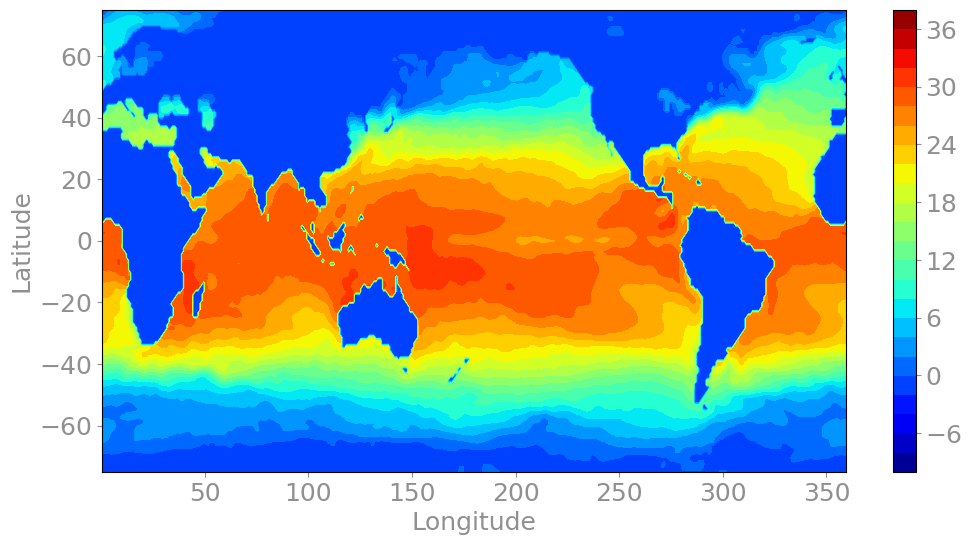

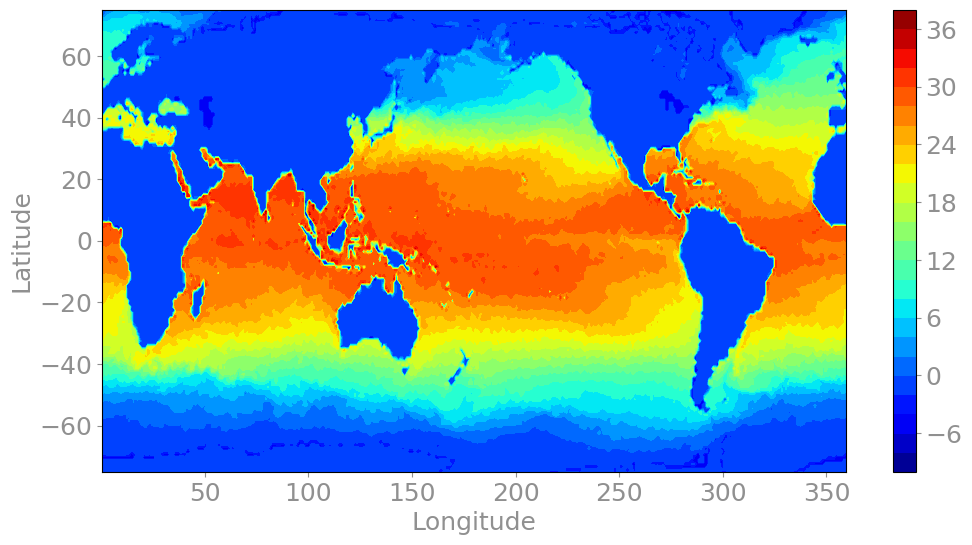

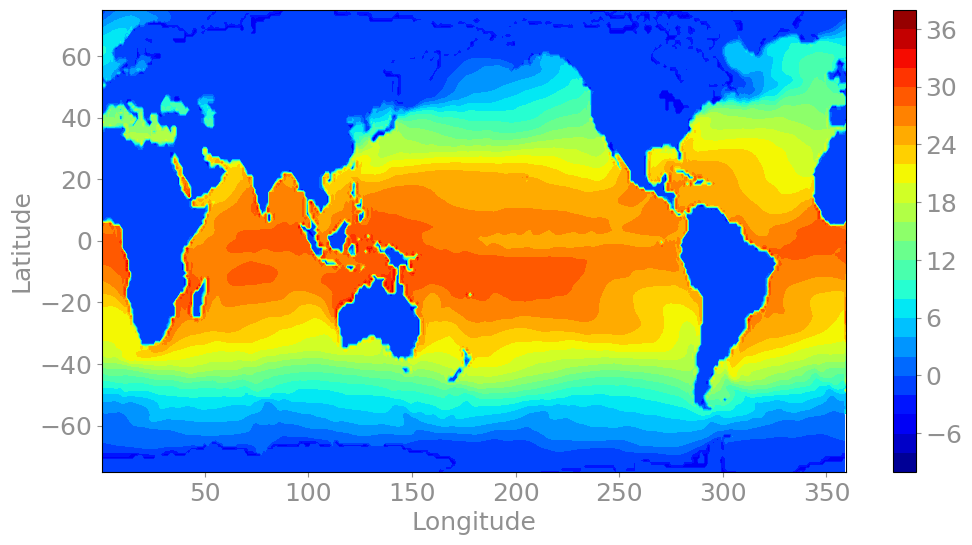

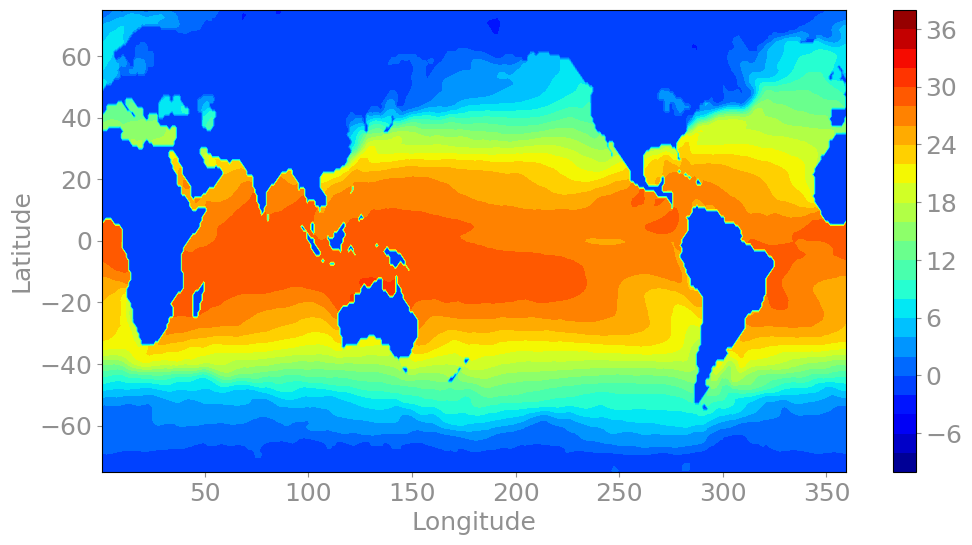

In [7]:
week = 100
levels = np.arange(-10,40,step=2)

plt.figure(figsize=(12,6))
plt.contourf(noaa_lon,noaa_lat,test_true[week],levels=levels)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar()
plt.ylim((-75,75))
plt.savefig('True_week_100.png')
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(noaa_lon,noaa_lat,test_hycom[week],levels=levels)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar()
plt.ylim((-75,75))
plt.savefig('HYCOM_week_100.png')
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(noaa_lon,noaa_lat,test_cesm[week],levels=levels)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar()
plt.ylim((-75,75))
plt.savefig('CESM_week_100.png')
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(noaa_lon,noaa_lat,test_pred[week],levels=levels)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar()
plt.ylim((-75,75))
plt.savefig('RKHS_week_100.png')
plt.show()

### Find errors for varying offsets in the test window

In [8]:
mask = mask[0]
mask = mask.flatten()

In [9]:
# Get rid of redundant points - NOAA
flat_true = test_true.reshape(168,180*360)
flat_true = flat_true[:,mask==1]

# Get rid of redundant points - HYCOM
flat_hycom = test_hycom.reshape(168,180*360)
flat_hycom = flat_hycom[:,mask==1]

# Get rid of redundant points - CESM
flat_csem = test_cesm.reshape(168,180*360)
flat_csem = flat_csem[:,mask==1]

# Get rid of redundant points - Predicted
flat_pred = test_pred.reshape(168,180*360)
flat_pred = flat_pred[:,mask==1]

In [10]:
# Find 8 week breakdown RMSEs
offset_range = np.arange(1,9)
pred_rmse_list = []
csem_rmse_list = []
hycom_rmse_list = []

for offset in offset_range:
    temp_true = flat_true[offset::8]
    temp_pred = flat_pred[offset::8]
    temp_csem = flat_csem[offset::8]
    temp_hycom = flat_hycom[offset::8]
    
    rmse_pred = np.sqrt(np.mean((temp_true-temp_pred)**2))
    rmse_csem = np.sqrt(np.mean((temp_true-temp_csem)**2))
    rmse_hycom = np.sqrt(np.mean((temp_true-temp_hycom)**2))
    
    pred_rmse_list.append(rmse_pred)
    csem_rmse_list.append(rmse_csem)
    hycom_rmse_list.append(rmse_hycom)
    
print(pred_rmse_list)
print(csem_rmse_list)
print(hycom_rmse_list)

[0.83111966, 0.78701144, 0.79988194, 0.8095874, 0.8140453, 0.81621945, 0.82109344, 0.8282215]
[3.8841540560327754, 3.884029225040892, 3.885481094903468, 3.889227979769374, 3.895535980314761, 3.893459943634473, 3.895529598471322, 3.8923938978111177]
[4.433306607171738, 4.4396206617635725, 4.45361625563413, 4.454646084936434, 4.452373123676628, 4.44860727741193, 4.452277602020742, 4.455004646569739]


## Find regions of higher errors for prediction

In [11]:
# Reload data
test_true = np.load('sst_var_test',allow_pickle=True)

for week in range(test_true.shape[0]):
    test_true[week] = test_true[week]*mask[0]
    
# Load the Predicted fields
test_pred = np.load('RKHS_Predicted_Fields.npy')

# Load CESM fields
test_cesm = np.load('CESM_Test_Fields.npy')
for week in range(test_cesm.shape[0]):
    test_cesm[week] = test_cesm[week]*mask[0]

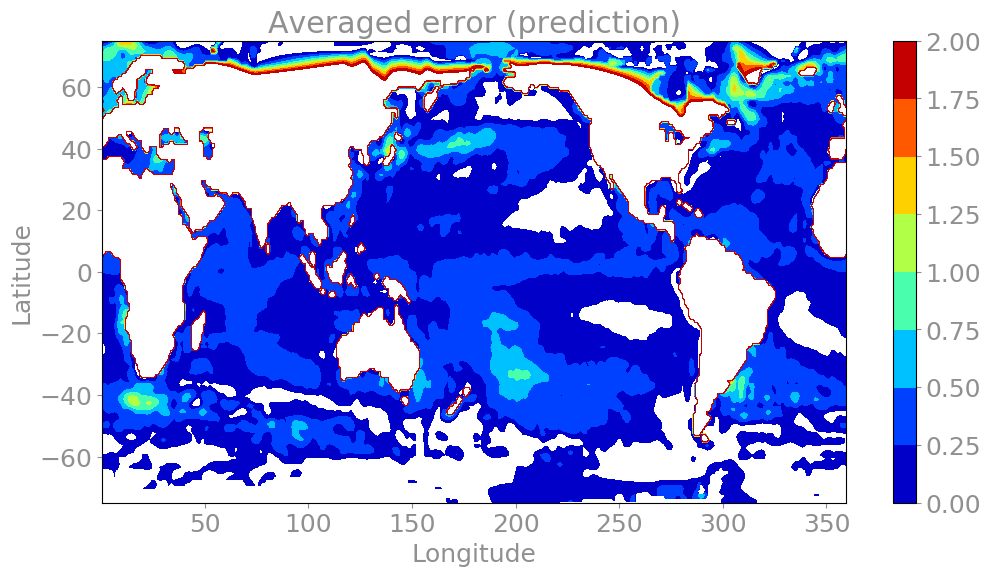

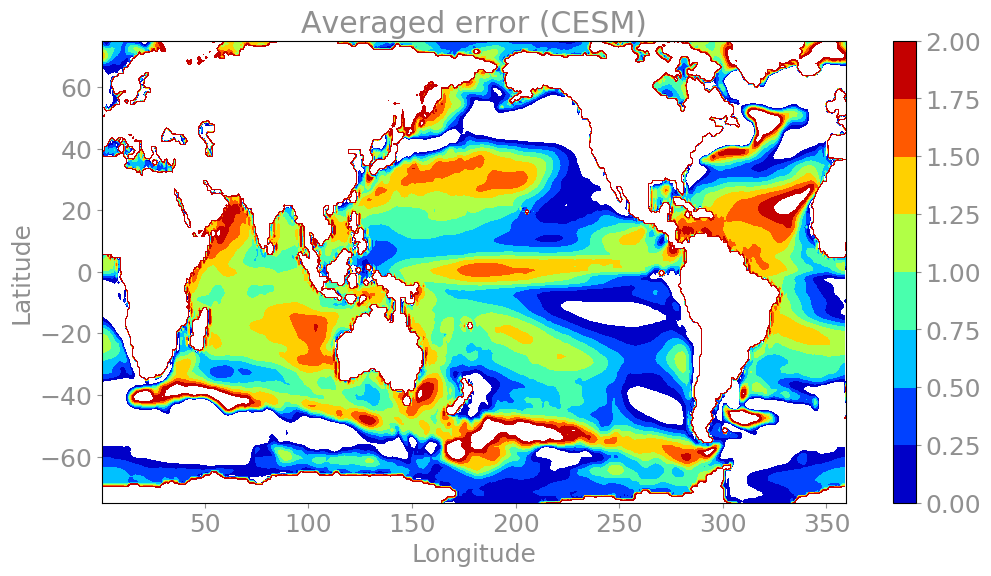

In [13]:
levels = np.linspace(0, 2, num=9)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
cx0 = ax.contourf(noaa_lon,noaa_lat,np.mean(test_true[:]-test_pred[:],axis=0),levels=levels)
ax.set_title('Averaged error (prediction)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
fig.colorbar(cx0,ax=ax)
ax.set_ylim((-75,75))
plt.savefig('Error_Prediction.png')
plt.show()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
cx0 = ax.contourf(noaa_lon,noaa_lat,np.mean(test_true[:]-test_cesm[:],axis=0),levels=levels)
ax.set_title('Averaged error (CESM)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
fig.colorbar(cx0,ax=ax)
ax.set_ylim((-75,75))
plt.savefig('Error_CESM.png')
plt.show()